In [3]:
from linares_plot import *
import os
os.chdir('C:\\Users\\David\\Documents\\GitHub\\interference_topography\\simulations\\model')
from model_ajustments import *

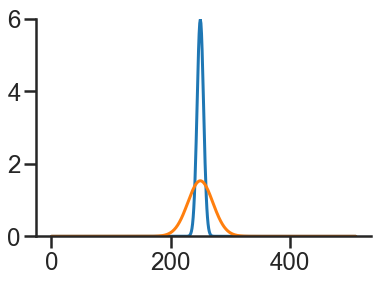

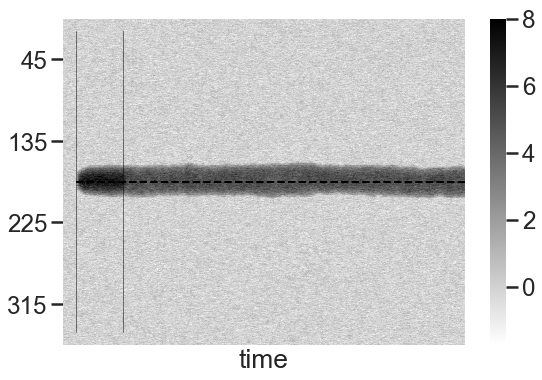

Simulation time: 21.0s
1 - with decode function
Gaussian fit


In [28]:
m = model(totalTime=3000, targ_onset=100,  presentation_period=350, angle_separation=22, tauE=9, tauI=4,  n_stims=1, 
    I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=225, kappa_I=15, 
    kappa_stim=75, N=512, plot_connectivity=True, plot_rate=False, plot_hm=True , plot_fit=False)

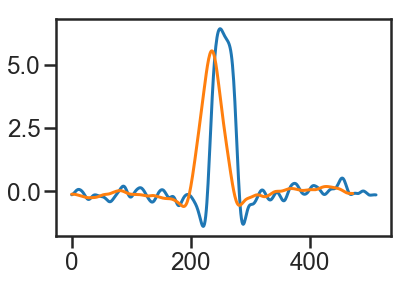

In [29]:
plt.plot(m[0])
windows_size=40  ##window size exclusion criteria
r = pd.DataFrame(m[0])[0].rolling(window=windows_size).mean()
r = r[~np.isnan(r)]        
smooth = np.array(list(r))
plt.plot(smooth)

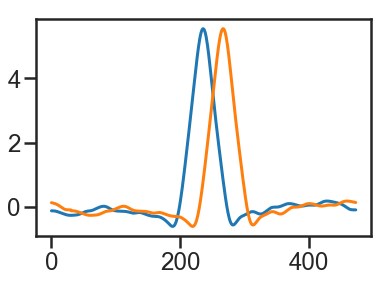

In [30]:
sep_deg=22
sep_neurons = sep_deg*512/360
plt.plot(smooth)
plt.plot(  np.roll(smooth, int(sep_neurons)) )

In [ ]:
m = model(totalTime=3000, targ_onset=100,  presentation_period=350, angle_separation=22, tauE=9, tauI=4,  n_stims=2, 
    I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=225, kappa_I=15, 
    kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

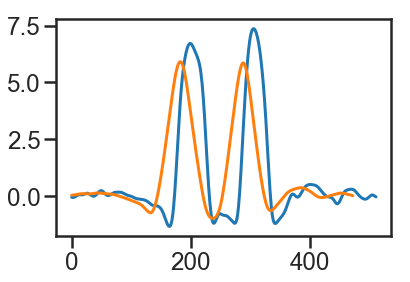

In [26]:
plt.plot(m[0])
windows_size=40  ##window size exclusion criteria
r = pd.DataFrame(m[0])[0].rolling(window=windows_size).mean()
r = r[~np.isnan(r)]        
smooth = np.array(list(r))
plt.plot(smooth)

In [6]:

def model(totalTime, targ_onset, presentation_period, angle_separation, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.022, GEI=0.019, 
 GIE=0.01 , GII=0.1, sigE=0.5, sigI=1.6, kappa_E=100, kappa_I=1.75, kappa_stim=100, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=True):
    #
    st_sim =time.time()
    dt=2
    nsteps=int(floor(totalTime/dt));
    origin = pi
    rE=zeros((N,1));
    rI=zeros((N,1));
    #Connectivities
    v_E=zeros((N));
    v_I=zeros((N));
    WE=zeros((N,N));
    WI=zeros((N,N));
    separation =  angle_separation*pi/360
    angle_target=180+angle_separation/2
    angle_distractor=180-angle_separation/2
    if n_stims==1:
        separation=0


    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) for f in range(0, len(theta))]
        ###    
        vE_NEW=roll(v_E_new,i)
        vI_NEW=roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    #
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.show(block=False)
    ##
    # Stims
    if n_stims==2:
        stimulus1=zeros((N))
        stimulus2=zeros((N))
        for i in range(0, N):
            stimulus1[i]=e**(kappa_stim*cos(theta[i] + origin - separation)) / (2*pi*scipy.special.i0(kappa_stim))
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin + separation)) / (2*pi*scipy.special.i0(kappa_stim))
        stimulus= (stimulus1 + stimulus2);
        stimulus=reshape(stimulus, (N,1))
    elif n_stims==1:
        stimulus2=zeros((N));
        for i in range(0, N):
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin)) / (2*pi*scipy.special.i0(kappa_stim))
        stimulus=stimulus2
        stimulus=reshape(stimulus, (N,1))
    ###
    ###
    stimon = floor(targ_onset/dt);
    stimoff = floor(targ_onset/dt) + floor(presentation_period/dt) ;
    #Simulation
    #generation of the noise and the connectivity between inhib and exit
    RE=zeros((N,nsteps));
    RI=zeros((N,nsteps));
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);
        #differential equations for connectivity
        IE= GEE*dot(WE,rE) - GIE*dot(WI,rI) + I0E*ones((N,1));
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
        #
        if i>stimon and i<stimoff:
            IE=IE+stimulus;
            II=II+stimulus;
        #
        #rates of exit and inhib
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        rEr=reshape(rE, N)
        rIr=reshape(rI, N)
        #drawnow
        RE[:,i] = rEr;
        RI[:,i] = rIr;
    #
    ## metrics
    if n_stims==2:
        interference = Interference_effects( [decode_rE(stimulus1)], [decode_rE(rE)], [decode_rE(stimulus2)])[0]

    p_targ1 = int((N * np.degrees(origin + separation))/360)
    p_targ2 = int((N * np.degrees(origin - separation))/360)
    #
    if plot_rate==True:
        #### plot dynamics
        fig = plt.figure()
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ1, :], 'b', label='target1')
        plt.plot(RE[p_targ2, :], 'r', label='target2')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    if plot_hm==True:
        #### plot heatmap
        RE_sorted=flipud(RE)
        plt.figure(figsize=(9,6))
        sns.heatmap(RE_sorted, cmap='binary', vmax=8)
        #plt.title('BUMP activity')
        #plt.ylabel('Angle')
        plt.xlabel('time')
        plt.plot([stimon, nsteps], [p_targ2, p_targ2], '--k', linewidth=2) ## flipped, so it is p_target 
        #plt.plot([stimon, nsteps], [p_targ1, p_targ1], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        #plt.plot([stimon, stimon,], [0+20, N-20], 'k-', label='onset')
        #plt.plot([stimoff, stimoff,], [0+20, N-20], 'k--', label='offset')
        plt.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
        plt.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)
        #plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')

    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    def gauss(x,mu,sigma,A):
        return A*exp(-(x-mu)**2/2/sigma**2)

    std_g = 999
    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)

    ### Fit
    #df_n_p=pd.DataFrame()
    #df_n_p['rE'] = rE.reshape(512)
    #r = df_n_p['rE'].rolling(window=20).mean()
    #number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 

    if number_of_bumps ==2:
        param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75], maxfev=10000)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angle_1=np.degrees(param[0]+pi)  
        estimated_angle_2=np.degrees(param[2]+pi)  
        estimated_angles = [estimated_angle_1, estimated_angle_2]
        estimated_angles.sort()
        bias_b1 = estimated_angles[0] -  np.degrees(origin - separation) ### change the error stuff
        bias_b2 =  np.degrees(origin + separation) - estimated_angles[1]
        final_bias = [bias_b1, bias_b2]
        skip_r_sq=False
        success=True
        decode_func = 0
        if n_stims==1:
            print('Error simultaion')
            bias_b1=999
            bias_b2=999
            estimated_angles=999
            final_bias=[999, 999]
            plot_fit=False
            skip_r_sq=True
            r_squared=0
            success=False ## to eliminate wrong simulations easily at the end
            decode_func = 0
        #
    #
    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y, maxfev=10000)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        if param[0]<0:
            estimated_angles =decode_rE(rE)
            print('1 - with decode function')
            decode_func = 1
        else:
            estimated_angles=np.degrees(param[0]+pi) 
            decode_func = 0 
        #
        bias_b1 = estimated_angles - np.degrees( origin - separation)
        bias_b2 = np.degrees(origin + separation) - estimated_angles  ## bias (positive means attraction)
        ###final_bias = [bias_b1, bias_b2]  
        final_bias = [bias_b1, bias_b2] # de la otra manera estas forzando la media todo el rato
        skip_r_sq=False
        success=True
        print('Gaussian fit')
        param_g, covs_g = curve_fit(gauss, X, y, maxfev=10000)
        std_g = param_g[1]




        if n_stims==1:
            estimated_angles=np.degrees(param[0]+pi)
            bias_b1 = np.degrees(origin) - estimated_angles ## con fit
            bias_b2 = 180 - decode_rE(rE) ## scon decode_rE
            final_bias = [abs(bias_b2), abs(bias_b2)]
    ##
    else:
        print('Error simultaion')
        bias_b1=999
        bias_b2=decode_rE(rE)
        estimated_angles=999
        final_bias=[999, 999]
        plot_fit=False
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end
        decode_func = 0

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    ##
    ### Output
    total_sep=np.degrees(2*separation)
    final_bias = np.mean(final_bias)
    #print(total_sep)
    return(IE, final_bias, bias_b1, bias_b2, rE, RE, estimated_angles, total_sep, kappa_E, kappa_I, r_squared, success, number_of_bumps, decode_func, std_g) #bias_b1, bias_b2)


###